In [46]:
# pip install fbprophet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from pylab import rcParams
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error

In [2]:
data=pd.read_csv('SoDa_MERRA2_lat4.847_lon6.975_1980-01-01_2020-12-31_501774438.csv',parse_dates=['# Date'],index_col=['# Date'])

In [3]:
ts=data['Rainfall'].resample('M').mean()

In [4]:
ts

# Date
1980-01-31     54.253944
1980-02-29    111.454992
1980-03-31    159.547680
1980-04-30    115.285752
1980-05-31    330.417864
                 ...    
2020-08-31     95.613480
2020-09-30    419.964840
2020-10-31    238.740084
2020-11-30    398.439720
2020-12-31    168.858828
Freq: M, Name: Rainfall, Length: 492, dtype: float64

In [5]:
ts.sort_index(inplace=True)
ts

# Date
1980-01-31     54.253944
1980-02-29    111.454992
1980-03-31    159.547680
1980-04-30    115.285752
1980-05-31    330.417864
                 ...    
2020-08-31     95.613480
2020-09-30    419.964840
2020-10-31    238.740084
2020-11-30    398.439720
2020-12-31    168.858828
Freq: M, Name: Rainfall, Length: 492, dtype: float64

<AxesSubplot:xlabel='# Date'>

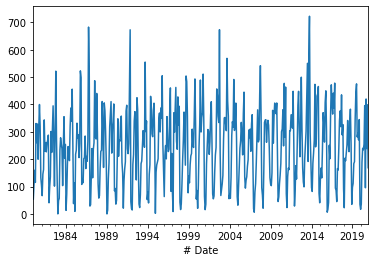

In [6]:
ts.plot()

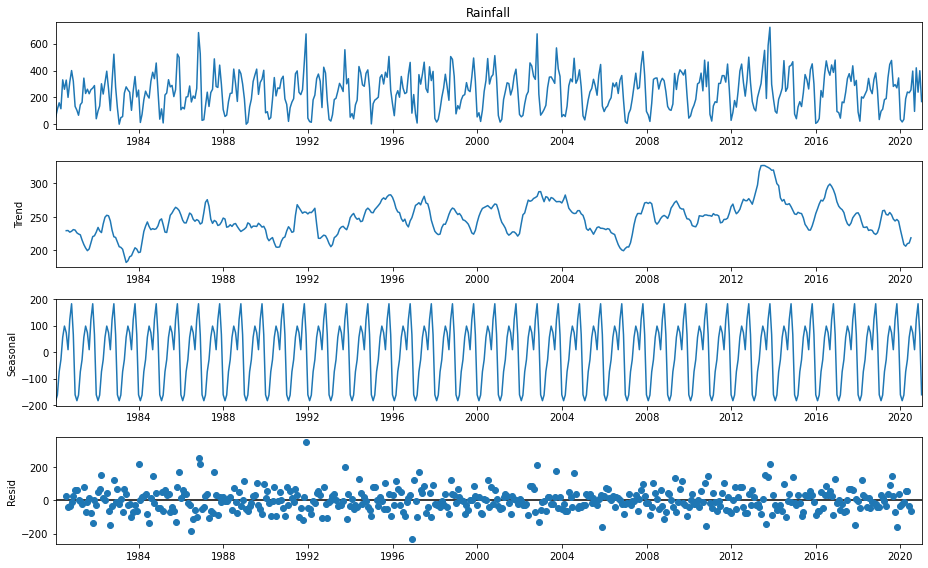

In [9]:
rcParams['figure.figsize'] = 13, 8
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()
# decomposition = sm.tsa.seasonal_decompose(ts, model='additive',period=12, extrapolate_trend = 12)

In [45]:
from statsmodels.tsa.stattools import adfuller

adftest=adfuller(ts)

# adftest

print('pvalue of adfuller test is: ', adftest[1])

pvalue of adfuller test is:  0.00011553333355725574


In [6]:
train = ts[:393]
test = ts[393:]

In [8]:
test

# Date
2012-10-31    499.521240
2012-11-30    309.625308
2012-12-31    168.815052
2013-01-31    116.465868
2013-02-28     98.887212
                 ...    
2020-08-31     95.613480
2020-09-30    419.964840
2020-10-31    238.740084
2020-11-30    398.439720
2020-12-31    168.858828
Freq: M, Name: Rainfall, Length: 99, dtype: float64

In [66]:
import itertools
p=range(0,10)
q=range(0,10)
d=range(0,2)

In [67]:
pdq_combination=list(itertools.product(p,d,q))
pdq_combination
len(pdq_combination)

200

In [68]:
rmse=[]
order1=[]

In [69]:
for pdq in pdq_combination:
    try:
        model=ARIMA(train,order=pdq).fit()
        pred=model.predict(start=len(train),end=(len(ts)-1))
        error=np.sqrt(mean_squared_error(test,pred))
        order1.append(pdq)
        rmse.append(error)
                           
    except:
        continue

In [63]:
results=pd.DataFrame(index=order1,data=rmse, columns=['RMSE'])

In [65]:
results

,RMSE
"(0, 0, 0)",147.344813
"(0, 0, 1)",146.611209
"(0, 0, 2)",146.353961
"(0, 0, 3)",146.337914
"(0, 0, 4)",146.383339
...,...
"(7, 1, 3)",134.935077
"(7, 1, 4)",141.734912
"(7, 1, 5)",145.491067
"(7, 1, 6)",140.978740


In [11]:
model= ARIMA(train,order=(7,1,7)).fit()

In [12]:
pred = model.predict(start = len(train),end = (len (ts)-1))
pred

2012-10-31    356.534140
2012-11-30    258.132914
2012-12-31    137.352330
2013-01-31     61.694963
2013-02-28     74.540661
                 ...    
2020-08-31    345.045148
2020-09-30    342.879714
2020-10-31    310.620325
2020-11-30    239.192367
2020-12-31    151.834819
Freq: M, Name: predicted_mean, Length: 99, dtype: float64

In [13]:
from sklearn.metrics import mean_squared_error

error = np.sqrt(mean_squared_error(test,pred))
error

94.89121902385695

<AxesSubplot:xlabel='# Date'>

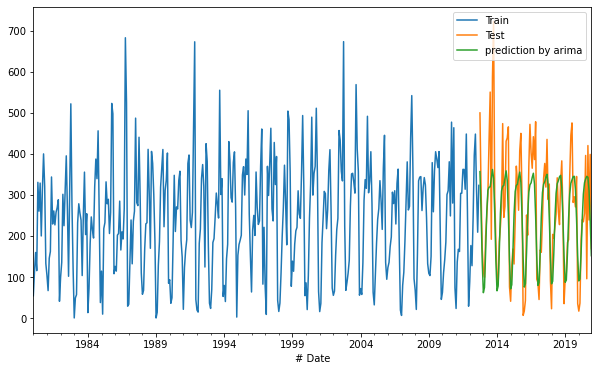

In [14]:
train.plot(legend=True, label='Train', figsize=(10,6))
test.plot(legend = True, label = 'Test')
pred.plot(legend=True, label = 'prediction by arima')

In [77]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [78]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [79]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, ts)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(1, 1, 3, 1)",14.000000
1,"(1, 2, 1, 3)",16.000000
2,"(3, 3, 0, 2)",18.000000
3,"(2, 3, 3, 0)",18.000000
4,"(3, 1, 2, 3)",20.000000
...,...,...
246,"(0, 0, 0, 0)",6518.049976
247,"(1, 0, 0, 0)",6519.981237
248,"(0, 1, 0, 0)",6519.983260
249,"(2, 0, 0, 0)",6520.674152


In [15]:
model = SARIMAX(ts, seasonal_order=(1, 1, 3, 12)).fit(dis=-1)
print(model.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                   Rainfall   No. Observations:                  492
Model:             SARIMAX(1, 0, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood               -2771.795
Date:                                    Mon, 11 Jul 2022   AIC                           5555.590
Time:                                            17:23:34   BIC                           5580.633
Sample:                                        01-31-1980   HQIC                          5565.434
                                             - 12-31-2020                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0678      0.040      1.677      0

In [16]:
pred = model.predict(start = len(train),end = (len (ts)-1))
pred

# Date
2012-10-31    424.188288
2012-11-30    321.443214
2012-12-31     80.986804
2013-01-31     74.963753
2013-02-28     89.282174
                 ...    
2020-08-31    265.735469
2020-09-30    360.348791
2020-10-31    424.265342
2020-11-30    307.487516
2020-12-31     85.956990
Freq: M, Name: predicted_mean, Length: 99, dtype: float64

In [17]:
from sklearn.metrics import mean_squared_error

error = np.sqrt(mean_squared_error(test,pred))
error

80.22372672824329

<AxesSubplot:xlabel='# Date'>

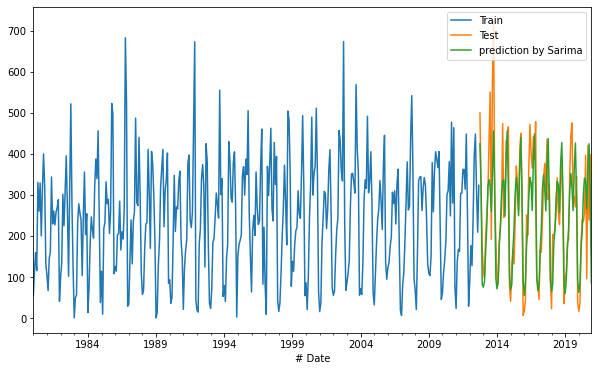

In [18]:
train.plot(legend=True, label='Train', figsize=(10,6))
test.plot(legend = True, label = 'Test')
pred.plot(legend=True, label = 'prediction by Sarima')

In [132]:
import pmdarima as pm
model = pm.auto_arima(ts, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      max_d=2,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=6218.705, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6951.180, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=6218.442, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=6588.425, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=6219.166, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.49 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=6107.963, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=6245.480, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6091.797, Time=0.15 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=6080.575, Time=0.15 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=6078.378, Time=0.21 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=6055.891, Time=0.29 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=6032.974, Time=1.53 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=6043.836, Time=1.26 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : 

In [19]:
model= ARIMA(train,order=(5,0,1)).fit()

In [20]:
pred = model.predict(start = len(train),end = (len (ts)-1))

In [21]:
error = np.sqrt(mean_squared_error(test,pred))
error

144.48897786734463

<AxesSubplot:xlabel='# Date'>

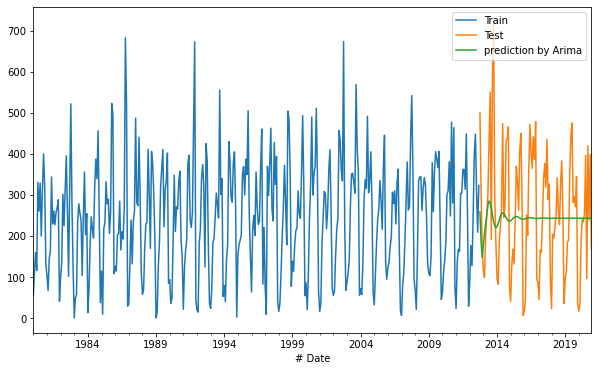

In [23]:
train.plot(legend=True, label='Train', figsize=(10,6))
test.plot(legend = True, label = 'Test')
pred.plot(legend=True, label = 'prediction by Arima')

In [24]:
predictions=model.predict(start=492, end=600, exog=None, dynamic=True)

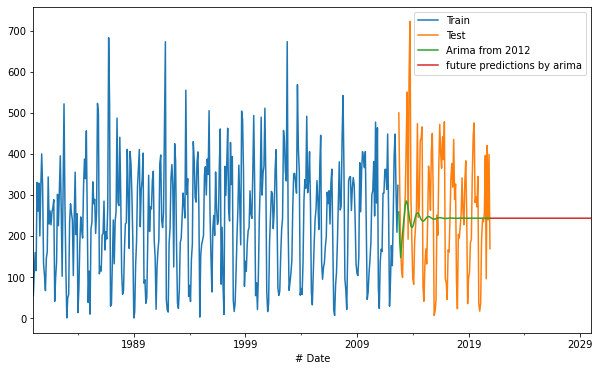

In [25]:
train.plot(legend=True, label='Train', figsize=(10,6))
test.plot(legend = True, label = 'Test')
pred.plot(legend=True, label = 'Arima from 2012' )
predictions.plot(legend=True, label = 'future predictions by arima')
plt.savefig('Arima.jpg')

In [42]:
model = SARIMAX(ts, order=(1, 1, 3), seasonal_order=(0, 1, 0, 12)).fit(dis=-1)
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            Rainfall   No. Observations:                  492
Model:             SARIMAX(1, 1, 3)x(0, 1, [], 12)   Log Likelihood               -2894.806
Date:                             Mon, 11 Jul 2022   AIC                           5799.611
Time:                                     18:21:25   BIC                           5820.470
Sample:                                 01-31-1980   HQIC                          5807.811
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9189      0.022    -41.165      0.000      -0.963      -0.875
ma.L1          0.0189      

In [43]:
pred = model.predict(start = len(train),end = (len (ts)-1))
pred

# Date
2012-10-31    435.626548
2012-11-30    278.076824
2012-12-31     17.312595
2013-01-31    116.324317
2013-02-28    156.118536
                 ...    
2020-08-31    298.598340
2020-09-30    257.801723
2020-10-31    316.112380
2020-11-30    297.529339
2020-12-31     86.231656
Freq: M, Name: predicted_mean, Length: 99, dtype: float64

In [44]:
from sklearn.metrics import mean_squared_error

error = np.sqrt(mean_squared_error(test,pred))
error

101.9221314045467

<AxesSubplot:xlabel='# Date'>

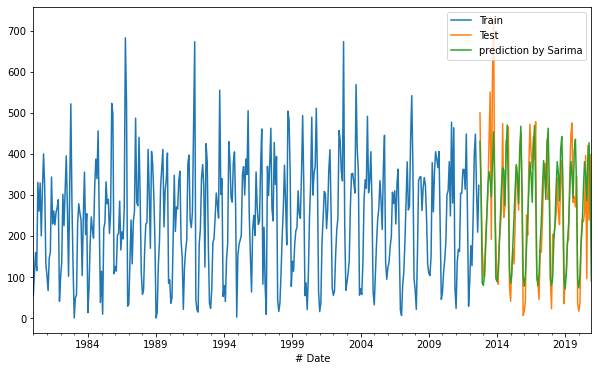

In [29]:
train.plot(legend=True, label='Train', figsize=(10,6))
test.plot(legend = True, label = 'Test')
pred.plot(legend=True, label = 'prediction by Sarima')

In [30]:
predictions=model.predict(start=492, end=600, exog=None, dynamic=True)

<AxesSubplot:xlabel='# Date'>

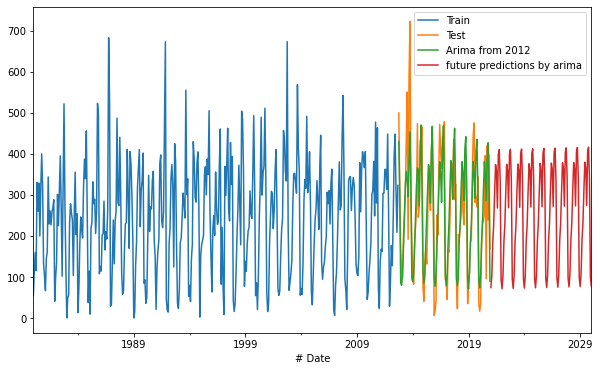

In [31]:
train.plot(legend=True, label='Train', figsize=(10,6))
test.plot(legend = True, label = 'Test')
pred.plot(legend=True, label = 'Arima from 2012' )
predictions.plot(legend=True, label = 'future predictions by arima')
# plt.savefig('Arima.jpg')

In [10]:
model=sm.tsa.statespace.SARIMAX(ts,order=(5, 0, 1),seasonal_order=(1,1,3,12))
pred=model.fit()
print(pred.summary())


                                         SARIMAX Results                                          
Dep. Variable:                                   Rainfall   No. Observations:                  492
Model:             SARIMAX(5, 0, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood               -2770.774
Date:                                    Tue, 12 Jul 2022   AIC                           5563.548
Time:                                            09:47:32   BIC                           5609.460
Sample:                                        01-31-1980   HQIC                          5581.595
                                             - 12-31-2020                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0050     49.669   9.97e-05      1

In [26]:
pred_test = pred.predict(start = len(train),end = (len (ts)-1))


In [16]:
forecast = pred.predict(len(ts), len(ts)+30)
print(forecast)

2021-01-31     59.147745
2021-02-28     94.065362
2021-03-31    172.954901
2021-04-30    219.378336
2021-05-31    307.897349
2021-06-30    340.894215
2021-07-31    315.922537
2021-08-31    237.715314
2021-09-30    369.897724
2021-10-31    416.955517
2021-11-30    314.213542
2021-12-31     96.995252
2022-01-31     64.959958
2022-02-28     87.832518
2022-03-31    175.956513
2022-04-30    212.265026
2022-05-31    298.883319
2022-06-30    342.202359
2022-07-31    330.176649
2022-08-31    260.333633
2022-09-30    373.505184
2022-10-31    426.780014
2022-11-30    317.975692
2022-12-31     82.799176
2023-01-31     61.987678
2023-02-28     84.563896
2023-03-31    169.851172
2023-04-30    219.378193
2023-05-31    308.893726
2023-06-30    343.862859
2023-07-31    314.723599
Freq: M, Name: predicted_mean, dtype: float64


In [25]:
predictions=pred.predict(start=492, end=600, exog=None, dynamic=True)
predictions

2021-01-31     59.147745
2021-02-28     94.065362
2021-03-31    172.954901
2021-04-30    219.378336
2021-05-31    307.897349
                 ...    
2029-09-30    369.083959
2029-10-31    423.432261
2029-11-30    312.553963
2029-12-31     92.530381
2030-01-31     64.568161
Freq: M, Name: predicted_mean, Length: 109, dtype: float64

In [39]:

from sklearn.metrics import mean_squared_error

error = np.sqrt(mean_squared_error(test,pred))
error

79.14488726591433

<AxesSubplot:xlabel='# Date'>

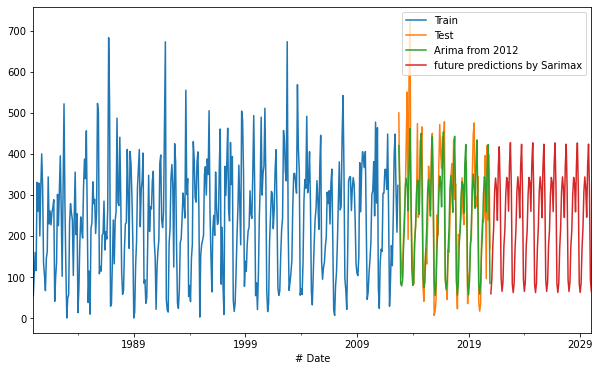

In [27]:
train.plot(legend=True, label='Train', figsize=(10,6))
test.plot(legend = True, label = 'Test')
pred_test.plot(legend=True, label = 'Arima from 2012' )
predictions.plot(legend=True, label = 'future predictions by Sarimax')
# plt.savefig('Arima.jpg')

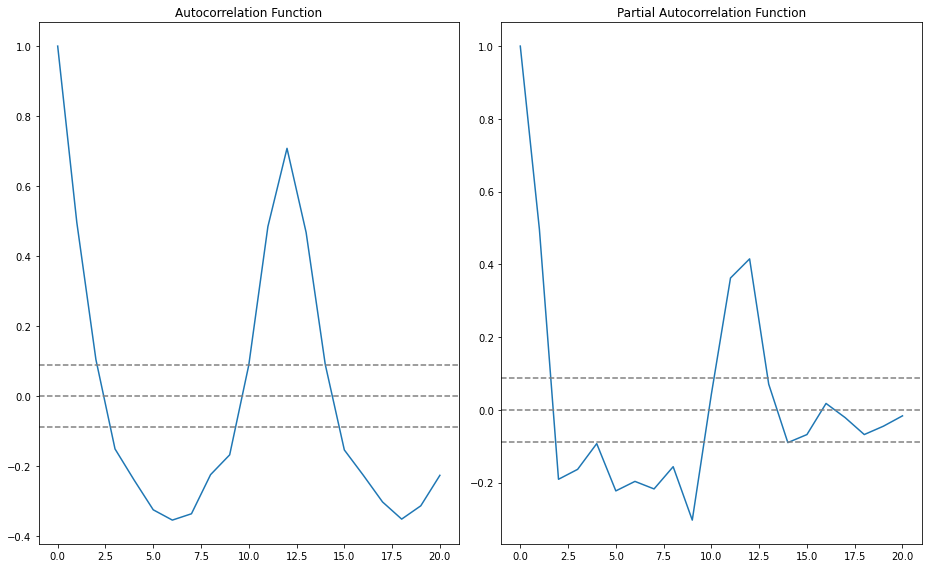

In [45]:
# ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts, nlags=20)
lag_pacf = pacf(ts, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [8]:
ts1=ts.reset_index()

In [12]:
ts1.columns = ['ds', 'y']
ts1.head()

,ds,y
0,1980-01-31,54.253944
1,1980-02-29,111.454992
2,1980-03-31,159.547680
3,1980-04-30,115.285752
4,1980-05-31,330.417864


In [38]:
m = Prophet()
m.fit(ts1)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=9, freq='Y')
forecast_prediction = m.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [41]:
forecast_prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1980-01-31,220.314151,-57.452241,128.448952,220.314151,220.314151,-188.243866,-188.243866,-188.243866,-188.243866,-188.243866,-188.243866,0.0,0.0,0.0,32.070285
1,1980-02-29,220.401264,-55.970145,132.628495,220.401264,220.401264,-179.484319,-179.484319,-179.484319,-179.484319,-179.484319,-179.484319,0.0,0.0,0.0,40.916945
2,1980-03-31,220.494385,56.274215,246.687533,220.494385,220.494385,-65.716240,-65.716240,-65.716240,-65.716240,-65.716240,-65.716240,0.0,0.0,0.0,154.778145
3,1980-04-30,220.584502,119.009104,308.082392,220.584502,220.584502,-10.478862,-10.478862,-10.478862,-10.478862,-10.478862,-10.478862,0.0,0.0,0.0,210.105640
4,1980-05-31,220.677623,189.669437,372.831615,220.677623,220.677623,64.998090,64.998090,64.998090,64.998090,64.998090,64.998090,0.0,0.0,0.0,285.675713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,2025-12-31,256.410279,15.240432,194.742967,256.234061,256.570683,-144.796830,-144.796830,-144.796830,-144.796830,-144.796830,-144.796830,0.0,0.0,0.0,111.613449
497,2026-12-31,256.995554,2.460421,192.724046,256.771875,257.212352,-159.530537,-159.530537,-159.530537,-159.530537,-159.530537,-159.530537,0.0,0.0,0.0,97.465016
498,2027-12-31,257.580828,-9.202455,170.157851,257.296711,257.853713,-174.420391,-174.420391,-174.420391,-174.420391,-174.420391,-174.420391,0.0,0.0,0.0,83.160437
499,2028-12-31,258.167706,36.027355,219.103768,257.822640,258.502855,-130.238088,-130.238088,-130.238088,-130.238088,-130.238088,-130.238088,0.0,0.0,0.0,127.929618


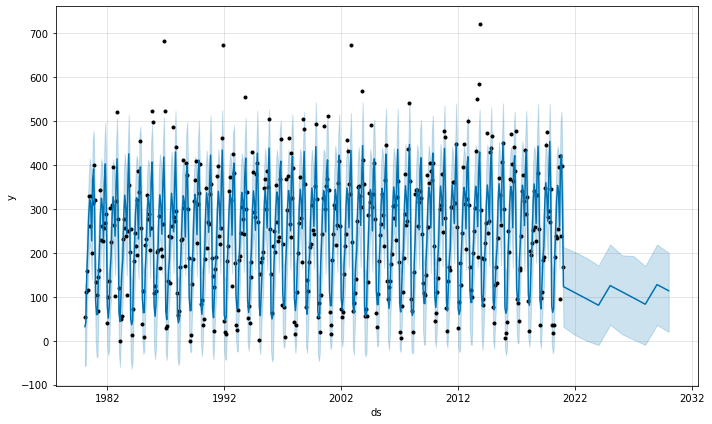

In [42]:
plot1 = m.plot(forecast_prediction)

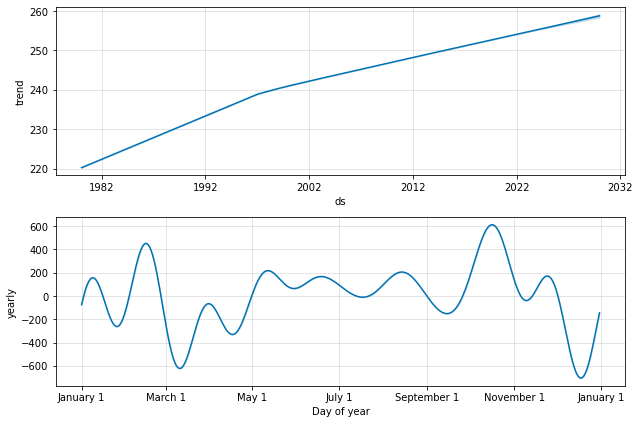

In [43]:
plot2 = m.plot_components(forecast_prediction)

In [52]:
from neuralprophet import NeuralProphet
import pandas as pd



m = NeuralProphet()

metrics = m.fit(ts1, freq="M")

forecast = m.predict(ts1)


INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 91.463% of the data.
INFO:NP.df_utils:Major frequency M corresponds to 91.463% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO:NP.df_utils:Defined frequency is equal to major frequency - M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True

  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.46E-02, min: 1.80E-01
INFO:NP.utils_torch:lr-range-test results: steep: 7.46E-02, min: 1.80E-01


  0%|          | 0/119 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.46E-02, min: 1.51E-01
INFO:NP.utils_torch:lr-range-test results: steep: 7.46E-02, min: 1.51E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.23E-02
INFO:NP.forecaster:lr-range-test selected learning rate: 8.23E-02
Epoch[247/247]: 100%|███████████| 247/247 [00:19<00:00, 12.87it/s, SmoothL1Loss=0.0114, MAE=54.7, RMSE=70.3, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 91.463% of the data.
INFO:NP.df_utils:Major frequency M corresponds to 91.463% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO:NP.df_utils:Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 91.463% of the data.
INFO:NP.df_utils:Major frequency M corresponds to 91.463% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal t

In [53]:
forecast

,ds,y,yhat1,residual1,trend,season_yearly
0,1980-01-31,54.253944,32.907017,-21.346927,220.215775,-187.308762
1,1980-02-29,111.454992,57.501148,-53.953844,220.181763,-162.680618
2,1980-03-31,159.547680,147.113968,-12.433712,220.145416,-73.031448
3,1980-04-30,115.285752,188.140671,72.854919,220.110229,-31.969557
4,1980-05-31,330.417864,277.891174,-52.526690,220.073883,57.817280
...,...,...,...,...,...,...
487,2020-08-31,95.613480,231.301773,135.688293,225.027603,6.274165
488,2020-09-30,419.964840,358.241577,-61.723263,224.281570,133.960007
489,2020-10-31,238.740084,394.581665,155.841581,223.510605,171.071060
490,2020-11-30,398.439720,288.664276,-109.775444,222.764572,65.899712


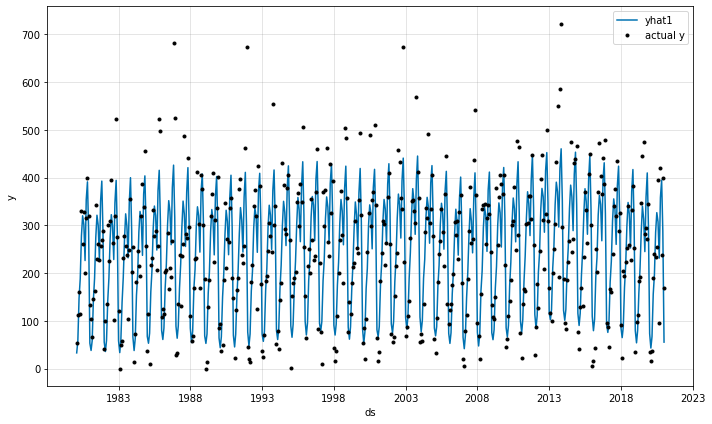

In [54]:
fig1 = m.plot(forecast)
